In [1]:
# Libraries
import pandas as pd
import numpy as np
import gpflow 

# Options
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# Data
# Read in metabolomics data
mbx = pd.read_csv('../examples/iHMP/data/iHMP_labeled_metabolomics.csv')
# Subset metabolites to labeled sets

# Get metabolite list
mbx_list = mbx.Metabolite
# Reshape metabolites for merge
mbx = mbx.iloc[:,7:].transpose().rename(columns = mbx_list)

# Read in metadata for timing of samples
meta = pd.read_csv('../examples/iHMP/data/iHMP_metadata.csv')
# Subset metadata to appropriate samples and columns of interest
meta = meta[meta['External ID'].isin(mbx.index)][['External ID', 'Participant ID', 
                                                  'date_of_receipt', 'diagnosis',
                                                  'hbi']]
meta.set_index('External ID', inplace = True)

# Make sure that intensities are numeric and log transform them
log_mbx = np.log(mbx.astype('double'))

# Calculate the means and standard deviations of each column
log_means = log_mbx.mean()
log_stds = log_mbx.std()

# Transform dataset
log_mbx = (log_mbx - log_means)/log_stds

# Merge metabolomics info to metadata
df = (meta.merge(mbx, #log_mbx, 
                 left_index = True, 
           right_index = True).
      drop_duplicates().
      rename(columns = {'Participant ID': 'id',
                        'date_of_receipt': 'date'#,
#                         0: 'intensity'
                       }))

# Fix the date column
df.date = pd.to_datetime(df.date)

# Now scale the dates compared to the earliest date
min_date = df.date.min()
df['days_from_start'] = (df.date - min_date).dt.days

# Drop columns that aren't needed (drop id for the moment)
df = df.drop(columns=['date'])#, 'id'])

# Drop duplicate metabolites
df = df.loc[:,~df.columns.duplicated()]

# Only keep CD observations because they have hbi
df = df.query("diagnosis == 'CD'").drop(columns = ['diagnosis'])

# Only keep non-missing HBI for the moment
df = df[df.hbi.notna()]

# Standardize hbi and days for convergence properties
df.days_from_start = (df.days_from_start - df.days_from_start.mean())/df.days_from_start.std()
df.hbi = (df.hbi - df.hbi.mean())/df.hbi.std()

# Store individual information look up vectors
n_id = df.id.nunique()
id_list = df.id.unique()
id_vals = df.id.values
id_idx = np.array([np.where(id_list == x)[0][0] for x in id_vals])
df['id'] = id_idx

print(df.shape)
df.head()

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(241, 554)


,id,hbi,12.13-diHOME,9.10-diHOME,caproate,heptanoate,hydrocinnamate,mandelate,2-hydroxyoctanoate,3-hydroxyoctanoate,...,C16:1 LPC plasmalogen,C18:1 LPC plasmalogen,C18:0 LPE-A,C18:0 LPE-B,C22:6 LPE,sphingosine-isomer1,sphingosine-isomer2,sphingosine-isomer3,C14:0 SM,days_from_start
CSM5FZ3N,0,0.628714,942546.0,1418451.0,2194.0,NaN,38180.0,5893.0,NaN,4174.0,...,287048.0,453688.0,9997928.0,3579319.0,2066660.0,274385476.0,136360623.0,2.119068e+08,36328.0,-1.821219
CSM5FZ3T,1,2.563836,470132.0,416924.0,28.0,NaN,11781.0,6345.0,NaN,5257.0,...,1639623.0,3991478.0,69914375.0,6996249.0,15657037.0,70872089.0,5868952.0,3.456104e+09,119223.0,-1.589634
CSM5FZ44,1,1.789787,720369.0,1198835.0,436.0,NaN,8721.0,14372.0,NaN,5462.0,...,68416.0,22760.0,12300553.0,1812524.0,7134468.0,90077297.0,10050253.0,9.373580e+08,NaN,-1.307705
CSM5FZ4C,0,0.241690,584730.0,1955625.0,2305.0,NaN,69475.0,10406.0,NaN,6601.0,...,113495.0,130737.0,16335239.0,13177075.0,4447184.0,121055143.0,65245288.0,3.015463e+08,51577.0,-1.539290
CSM5MCU4,2,-0.919384,856432.0,994782.0,2953.0,NaN,15982.0,6027.0,420774.0,9123.0,...,303069.0,390814.0,15592389.0,1691861.0,6823317.0,4844449.0,3177299.0,3.002798e+08,369795.0,-1.272464


In [37]:
foo = gpflow.models.VGP(data = 
          (df[['id', 'hbi', 'days_from_start']].to_numpy().reshape(-1, 3),
           df[[m]].isna().astype(int).to_numpy().reshape(-1, 1)),
         kernel = Categorical(active_dims=[0]),
         likelihood = gpflow.likelihoods.Gaussian())

In [21]:
m = 'heptanoate'
kernel_list = [gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Linear()]
stage_one = full_kernel_search(
    X=df[['id', 'hbi', 'days_from_start']].to_numpy().reshape(-1, 3),
    Y=df[[m]].isna().astype(int).to_numpy().reshape(-1, 1),
            kern_list=kernel_list,
            cat_vars=[0],
            max_depth=3,
            early_stopping=True,
            prune=True,
            keep_all=False,
            lik='bernoulli',
            verbose=True)

Working on depth 1 now
Working on feature 0 now
Current kernel being tested: categorical[0]
Current kernel being tested: constantslice(None, None, None)
Working on feature 1 now
Current kernel being tested: squared_exponential[1]
Current kernel being tested: linear[1]
Working on feature 2 now
Current kernel being tested: squared_exponential[2]
Current kernel being tested: linear[2]
Working on depth 2 now
Working on feature 0 now
Current kernel being tested: categorical[0]
Working on feature 1 now
Current kernel being tested: squared_exponential[1]
Current kernel being tested: linear[1]
Working on feature 2 now
Current kernel being tested: squared_exponential[2]
Current kernel being tested: linear[2]
Working on feature 0 now
Current kernel being tested: categorical[0]
Working on feature 1 now
Current kernel being tested: squared_exponential[1]
Current kernel being tested: linear[1]
Working on feature 2 now
Current kernel being tested: squared_exponential[2]
Current kernel being tested: 

In [22]:
min([(i[2], k) for k, i in stage_one[0].items()])

(275.66, 'categorical[0]')

In [23]:
stage_one[0]['categorical[0]'][1]

name,class,transform,prior,trainable,shape,dtype,value
VGP.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.66977815]
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.385755808234789
VGP.q_mu,Parameter,Identity,,True,"(241, 1)",float64,[[9.60984730e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 241, 241)",float64,"[[[5.99445235e-01, 0.00000000e+00, 0.00000000e+00..."


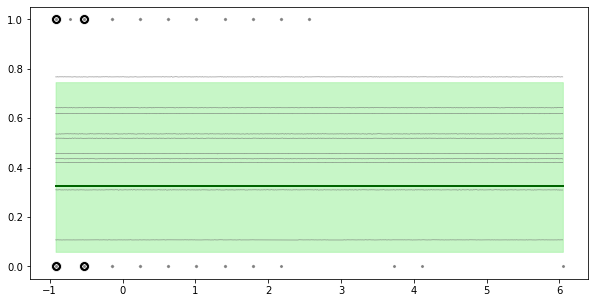

In [24]:
p = gp_predict_fun(
    stage_one[0]['categorical[0]'][1], 
    x_idx=1, 
    unit_idx=0,
    unit_label=5
)

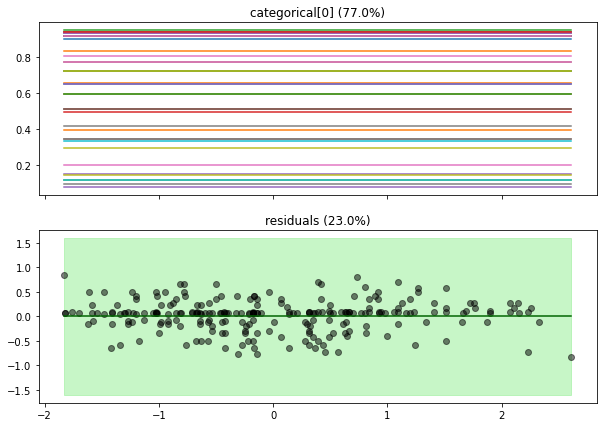

In [41]:
pred_kernel_parts(stage_one[0]['categorical[0]'][1],
                 'categorical[0]',
                 x_idx=2,
                 lik='bernoulli')

In [42]:
m = 'heptanoate'
kernel_list = [gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Linear()]
stage_two = full_kernel_search(
    X=df[['id', 'hbi', 'days_from_start']].to_numpy().reshape(-1, 3),
    Y=df[[m]].to_numpy().reshape(-1, 1),
            kern_list=kernel_list,
            cat_vars=[0],
            max_depth=3,
            early_stopping=True,
            prune=True,
            keep_all=False,
            lik='gamma',
            verbose=True)

Working on depth 1 now
Working on feature 0 now
Current kernel being tested: categorical[0]
Current kernel being tested: constantslice(None, None, None)
Working on feature 1 now
Current kernel being tested: squared_exponential[1]
Current kernel being tested: linear[1]
Working on feature 2 now
Current kernel being tested: squared_exponential[2]
Current kernel being tested: linear[2]
Working on depth 2 now
Working on feature 0 now
Current kernel being tested: categorical[0]
Working on feature 1 now
Current kernel being tested: squared_exponential[1]
Current kernel being tested: linear[1]
Working on feature 2 now
Current kernel being tested: squared_exponential[2]
Current kernel being tested: linear[2]
Working on feature 0 now
Current kernel being tested: categorical[0]
Working on feature 1 now
Current kernel being tested: squared_exponential[1]
Current kernel being tested: linear[1]
Working on feature 2 now
Current kernel being tested: squared_exponential[2]
Current kernel being tested: 

In [43]:
min([(i[2], k) for k, i in stage_two[0].items()])

(1566.66, 'categorical[0]')

In [44]:
stage_two[0]['categorical[0]*squared_exponential[1]'][1]

name,class,transform,prior,trainable,shape,dtype,value
VGP.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[7.35616937]
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,2.9322922405869165
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0689449704080192
VGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,2.1090082114576503
VGP.likelihood.shape,Parameter,Softplus,,True,(),float64,0.7582897990142756
VGP.q_mu,Parameter,Identity,,True,"(83, 1)",float64,[[1.64509839e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 83, 83)",float64,"[[[1.80625333e-01, 0.00000000e+00, 0.00000000e+00..."


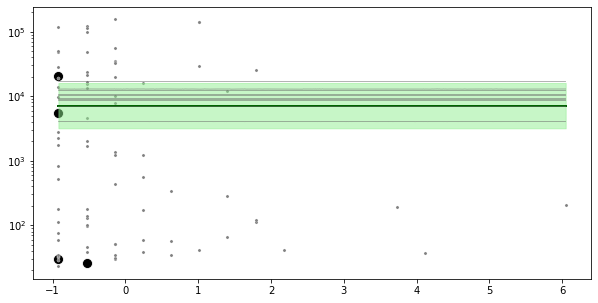

In [45]:
p = gp_predict_fun(
    stage_two[0]['categorical[0]'][1], 
    x_idx=1, 
    unit_idx=0,
    unit_label=5
).set_yscale('log')

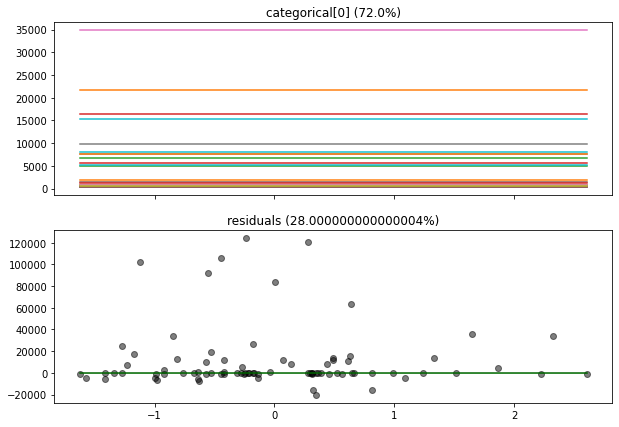

In [46]:
pred_kernel_parts(stage_two[0]['categorical[0]'][1],
                 'categorical[0]',
                 x_idx=2,
                 lik='gamma')

In [57]:
[(i, stage_two[0][i][2]) for i,j in stage_two[0].items()]

[('categorical[0]', 1566.66),
 ('categorical[0]+squared_exponential[1]', 1574.76),
 ('categorical[0]+linear[1]', 1568.02),
 ('categorical[0]+squared_exponential[2]', 1575.5),
 ('categorical[0]+linear[2]', 1571.08),
 ('categorical[0]*squared_exponential[1]', 1570.37),
 ('categorical[0]*linear[1]', 1621.96),
 ('categorical[0]*squared_exponential[2]', 1574.91),
 ('categorical[0]*linear[2]', 1618.81)]

In [30]:
stage_two[3]

[1.833]

In [48]:
# Get standardized (Pearson) residuals
mean_y, var_y = stage_two[0][stage_two[2]][1].predict_y(stage_two[0][stage_two[2]][1].data[0])

In [49]:
np.var(((stage_two[0][stage_two[2]][1].data[1] - mean_y)/np.sqrt(var_y)).numpy())

1.254124797893419

(array([46., 10., 13.,  7.,  3.,  1.,  2.,  0.,  0.,  1.]),
 array([-0.71425842, -0.09496377,  0.52433087,  1.14362552,  1.76292016,
         2.38221481,  3.00150945,  3.6208041 ,  4.24009874,  4.85939339,
         5.47868803]),
 <BarContainer object of 10 artists>)

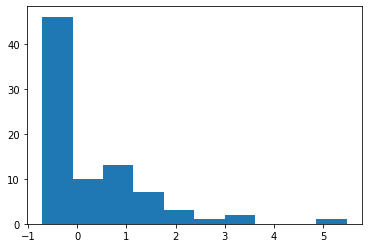

In [50]:
plt.hist(((stage_two[0][stage_two[2]][1].data[1] - mean_y)/np.sqrt(var_y)).numpy())

Let's now do this process for a larger list of metabolites.

In [52]:
# Specify kernels to search over for continuous features
kernel_list = [gpflow.kernels.SquaredExponential()]#,
               #gpflow.kernels.Matern12(),
               #gpflow.kernels.Linear()]

# Number of metabolites
n_met = 30

# Run this process for multiple metabolites independently
with tqdm_joblib(tqdm(desc="Kernel search", total=n_met)) as progress_bar:
    search_out = Parallel(n_jobs=-2, verbose=1)(delayed(full_kernel_search)(
            X=df[['id', 'hbi', 'days_from_start']].to_numpy().reshape(-1, 3),
            Y=df[[m]].to_numpy().reshape(-1, 1),
            kern_list=kernel_list,
            cat_vars=[0],
            max_depth=3,
            early_stopping=True,
            prune=True,
            keep_all=False,
            lik='gamma')
        for m in mbx_list[:n_met])

# Transform list output into dictionary to pull of metabolites of interest
model_dict = {k: v[0] for k,v in zip(mbx_list[:n_met], search_out)}

Kernel search:   0%|                                     | 0/30 [00:00<?, ?it/s][Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method Categorical.K of <__main__.Categorical object at 0x7faaaf5c5940>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

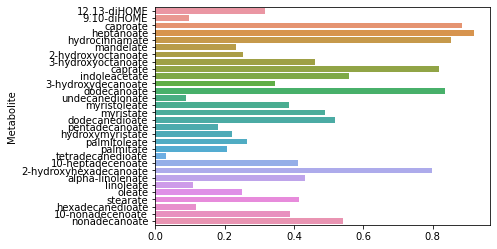

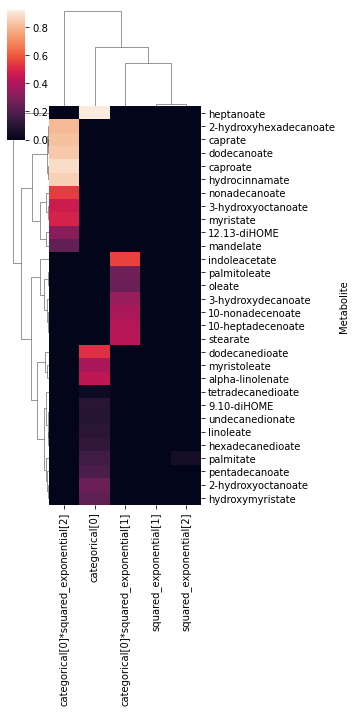

In [53]:
var_explained = [1-(x[3][-1]/sum(x[3])) if sum(x[3])>0 else 0 for x in search_out]
var_components = [x[3] for x in search_out]
var_percent = [[y/sum(x) if sum(x) > 0 else 0 for y in x][:-1] for x in var_components]

import seaborn as sns
sns.barplot(y=mbx_list[:n_met], 
            x=var_explained)

kernels = [x[2].split('+') for x in search_out]
distinct_kernels = np.unique([item for sublist in kernels for item in sublist])
kernel_array = np.zeros(shape=(len(kernels), len(distinct_kernels)))
kernel_idxs = np.vstack([sum([np.where(distinct_kernels==y, 1, 0) for y in x]) for x in kernels])

# Just fill in indicators now
kernel_array[kernel_idxs == 1] = [x for y in var_percent for x in y]

sns.clustermap(pd.DataFrame(kernel_array, 
                            index=mbx_list[:n_met],
                            columns=distinct_kernels),
              figsize=(5,10))

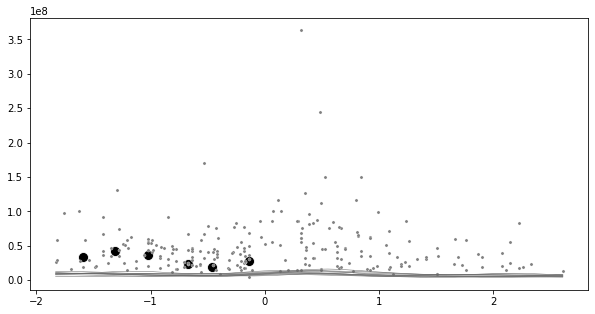

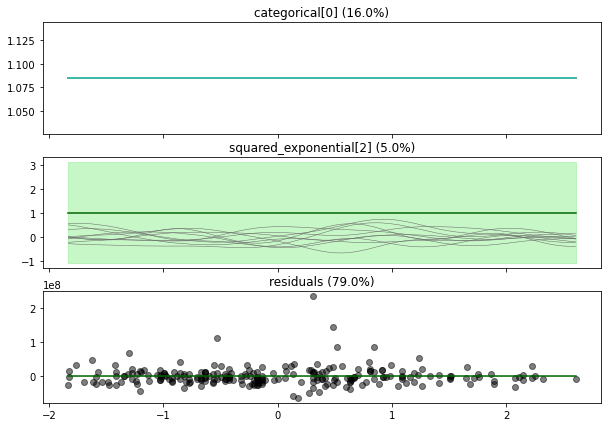

In [67]:
mbx_idx = np.argwhere([x == 'palmitate' for x in mbx_list]).tolist()[0][0]
cur_metabolite = mbx_list[mbx_idx] #'heptanoate'#'ketodeoxycholate'#'17-methylstearate'#'chenodeoxycholate'#'mandelate'#'heptanoate'
cur_kernel = search_out[mbx_idx][2] #'categorical[0]+linear[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*linear[2]'
# observed_data = df[['id', 'hbi', 'days_from_start', cur_metabolite]].dropna()
# Plot posterior distribution
p = gp_predict_fun(
    model_dict[cur_metabolite][cur_kernel][1], 
    x_idx=2, 
    unit_idx=0#,
    #unit_label=10
)

# Print resulting decomposition
pred_kernel_parts(model_dict[cur_metabolite][cur_kernel][1],
                  cur_kernel,
                  x_idx=2,
                 lik='gamma')

<AxesSubplot:xlabel='days_from_start', ylabel='mandelate'>

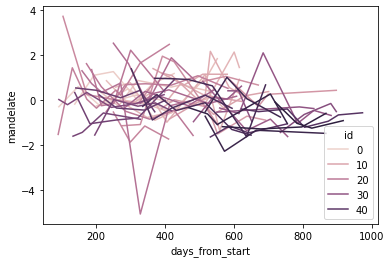

In [36]:
sns.lineplot(data=df, x="days_from_start", y="mandelate", hue="id")

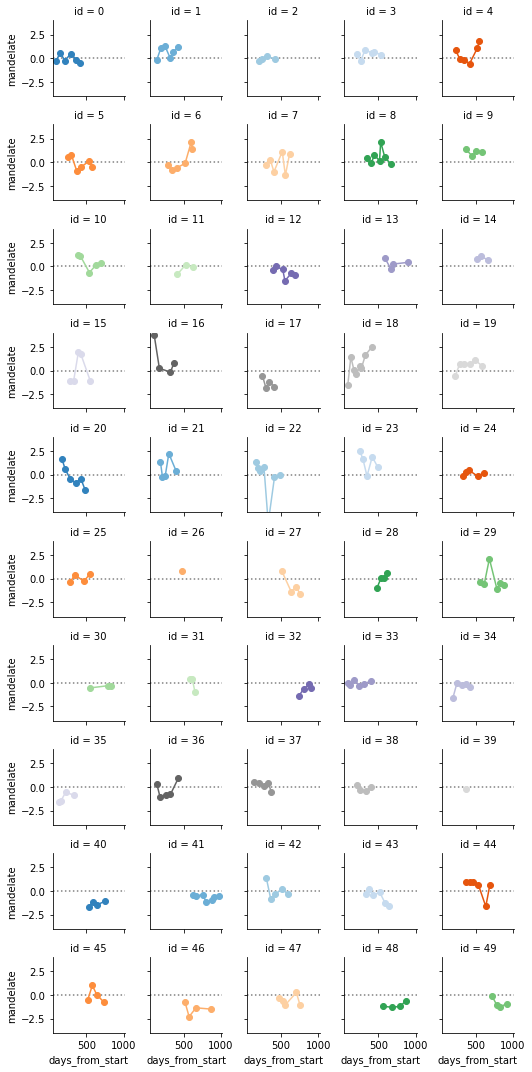

In [78]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df[['id', 'days_from_start', 'mandelate']].sort_values(by=['id', 'days_from_start']), 
                     col="id", hue="id", palette="tab20c",
                     col_wrap=5, height=1.5)

# Draw a horizontal line to show the starting point
grid.refline(y=0, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "days_from_start", "mandelate", marker="o")

# Adjust the tick positions and labels
grid.set(ylim=(-4, 4))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)